In [23]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnchoredText

import seaborn as sns
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)

from pathlib import Path
import os,sys
import h5py
import sys 
import pickle as pkl
import time

import nept
sys.path.append('../PreProcessing/')  
sys.path.append('../TrackingAnalyses/')  
sys.path.append('../Lib/')
sys.path.append('../misc/')
sys.path.append('../Analyses/')
from filters_ag import *

from importlib import reload  # Python 3.4+ only.
import pre_process_neuralynx as PPN
import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import stats_functions as StatsF
import plot_functions as PF



In [58]:
PPN=reload(PPN)
TMF=reload(TMF)
SF = reload(SF)
ST = reload(ST)
StatsF = reload(StatsF)
PF = reload(PF)
SLHD = reload(SLHD)

In [2]:
# OAKPaths
oakPaths = {}
oakPaths['Root'] = Path('/mnt/o/giocomo/alexg/')
oakPaths['Clustered'] = Path('/mnt/o/giocomo/alexg/Clustered/')
oakPaths['PreProcessed'] = Path('/mnt/o/giocomo/alexg/PreProcessed/')
oakPaths['Raw'] = Path('/mnt/o/giocomo/alexg/RawData/InVivo/')
oakPaths['Analyses'] = Path('/mnt/o/giocomo/alexg/Analyses')


In [136]:
def getSessionPaths(rootPath, session,step):
    tmp = session.split('_')
    animal = tmp[0]
    task = tmp[1]
    date = tmp[2]

    Paths = {}
    Paths['session'] = session
    Paths['animal']=animal
    Paths['task'] = task
    Paths['date'] = date
    Paths['step'] = step
    Paths['Clusters'] = rootPath['Clustered'] / animal /(session+'_KSClusters')
    Paths['Raw'] = rootPath['Raw'] / animal / session
    Paths['PreProcessed'] = rootPath['PreProcessed'] / animal / (session + '_Results')
    Paths['ClusterTable'] = rootPath['Clustered'] / animal / (animal+'_ClusteringSummary.json')
    Paths['Analyses'] = rootPath['Analyses'] / animal/ (session + '_Analyses')

    if not Paths['Clusters'].exists():
        print('Error, no Cluster Folder found.')
    if not Paths['PreProcessed'].exists():
        print('Error, no processed binaries found.')
    if not Paths['ClusterTable'].exists():
        print('Error, no clustering table found.')

    Paths['Analyses'].mkdir(parents=True, exist_ok=True)

    #Paths['PositionDat'] = Paths['Analyses'] / ('PositionVariables_{}ms.npz'.format(int(step*1000)))
    Paths['BehavTrackDat'] = Paths['Analyses'] / ('BehTrackVariables_{}ms.h5'.format(int(step*1000)))
    Paths['Cell_Spikes'] = Paths['Analyses'] / 'Cell_Spikes.json'
    Paths['Cell_Bin_Spikes'] = Paths['Analyses'] / ('Cell_Bin_Spikes_{}ms.npy'.format(int(step*1000)))
    Paths['Cell_FR'] = Paths['Analyses'] / ('Cell_FR_{}ms.npy'.format(int(step*1000)))
    
    Paths['Mua_Spikes'] = Paths['Analyses'] / 'Mua_Spikes.json'
    Paths['Mua_Bin_Spikes'] = Paths['Analyses'] / ('Mua_Bin_Spikes_{}ms.npy'.format(int(step*1000)))
    Paths['Mua_FR'] = Paths['Analyses'] / ('Mua_FR_{}ms.npy'.format(int(step*1000)))
    
    Paths['Spike_IDs'] = Paths['Analyses'] / 'Spike_IDs.json'
    
    Paths['ZoneAnalyses'] = Paths['Analyses'] / 'ZoneAnalyses.pkl'

    Paths['Plots'] = Paths['Analyses'] / 'Plots'
    Paths['Plots'].mkdir(parents=True, exist_ok=True)

    return Paths

def createZoneAnalysesDict(nCells, nMua):
    out = {}
    out['Zones'] = TMF.ZonesNames
    out['Partitions'] = ['all','CL','CR','CO','In','Out','Half1','Half2']
    out['InfoFields'] = ['counts','time','prob']
    
    eDF = pd.DataFrame(np.full((len(out['InfoFields']),TMF.nZones),np.nan),columns=TMF.ZonesNames,index=out['InfoFields'])
    out['ZoneInfo'] = {}
    for p in out['Partitions']:
        out['ZoneInfo'][p] = eDF.copy()

    out['nCells'] = nCells
    out['mMua'] = nMua
    
    nParts = len(out['Partitions'])
    eDF1 = pd.DataFrame(np.full((nParts,TMF.nZones),np.nan),columns=TMF.ZonesNames,index=out['Partitions'])
    eDF2 = pd.DataFrame(np.full((nCells,nParts),np.nan),columns=out['Partitions'])
    eDF3 = pd.DataFrame(np.full((nMua,nParts),np.nan),columns=out['Partitions'])
    
    out['FR_Zone'] = {'Cells':{},'Mua':{}}
    out['SI_Zone'] = {'Cells':eDF2.copy(),'Mua':eDF3.copy()}
    out['SIp_Zone'] = {'Cells':eDF2.copy(),'Mua':eDF3.copy()}
    for c in np.arange(nCells):
        out['FR_Zone']['Cells'][c] = eDF1.copy()
    
    for c in np.arange(nMua):
        out['FR_Zone']['Mua'][c] = eDF1.copy()
        
    return out

def getDatPartitions(PosDat):
    PartitionNames = ['all','CL','CR','CO','In','Out','Half1','Half2']
    nT = len(PosDat['t'])
    nP = len(PartitionNames)
    nT2 = np.floor(nT/2).astype(int)
    
    datPart = pd.DataFrame(np.zeros((nT,nP),dtype=bool), columns=PartitionNames)
    datPart['all'] = True
    
    datPart['CL'] = PosDat['EventDat']['CL'].astype(bool)
    datPart['CR'] = PosDat['EventDat']['CR'].astype(bool)
    datPart['CO'] = ~np.logical_or(datPart['CL'],datPart['CR'])
    
    datPart['Half1'][0:nT2]=True
    datPart['Half2'][nT2+1:]=True
    
    datPart['In'] = PosDat['InSeg']
    datPart['Out'] = PosDat['OutSeg']
    
    return datPart

In [117]:
animal = 'Li'
task = 'T3g'
date = '062718'
SR = 32000
step = 0.02 # in seconds
session = animal+'_'+task+'_'+date

sessionPaths = getSessionPaths(oakPaths,session,step)

In [32]:
import pickle as pkl
with sessionPaths['ZoneAnalyses'].open(mode='wb') as f:
    pkl.dump(dat,f)
with sessionPaths['ZoneAnalyses'].open(mode='rb') as f:
    dat2=pkl.load(f)


In [97]:
TMF = reload(TMF)
overwrite = 0
PosDat = TMF.getBehTrackData(sessionPaths, overwrite=overwrite)
datPart = getDatPartitions(PosDat)


Loading Beh Tracking Data
Complete.


In [66]:
SF = reload(SF)
spacing=25
occ_time_thr = 0.1 #s
sigma = 1
w = 4 # number of bins   

# get position info
OccInfo = ST.getTM_OccupationInfo(PosDat,spacing=spacing,occ_time_thr=occ_time_thr)

# get spikes and FR for cells and mua
cell_spikes, mua_spikes = SF.getSessionSpikes(sessionPaths)
cell_bin_spikes, mua_bin_spikes, ids= SF.getSessionBinSpikes(sessionPaths)
cell_FR, mua_FR = SF.getSessionFR(sessionPaths)


Loaded Spike Files.
Loading Spikes...
Binned Spike Files Loaded.
Loading FRs ...
FR Loaded.


In [143]:
nMua = len(ids['muas'])
nCells = len(ids['cells'])

ZoneRes = createZoneAnalysesDict(nCells,nMua)


In [148]:
zo={}
for p in ZoneRes['Partitions']:  
    zo[p] = PosDat['PosZones'][datPart[p]]
    ZoneRes['ZoneInfo'][p] = ST.getSeqInfo(zo[p])
    
for c in np.arange(nCells):
    fr = cell_FR[c]
    for p in ZoneRes['Partitions']:
        ZoneRes['FR_Zone']['Cells'][c].loc[p] = np.bincount(zo[p],fr[datPart[p]],TMF.nZones)/ZoneRes['ZoneInfo'][p].loc['counts']

for c in np.arange(nMua):
    fr = mua_FR[c]
    for p in ZoneRes['Partitions']:
        ZoneRes['FR_Zone']['Mua'][c].loc[p] = np.bincount(zo[p],fr[datPart[p]],TMF.nZones)/ZoneRes['ZoneInfo'][p].loc['counts']
#FR_ByZone = np.bincount(PosDat['PosZones'],smFR,TMF.nZones).astype(int)

In [156]:
np.corrcoef(ZoneRes['FR_Zone']['Cells'][1].iloc[1:4])

array([[1.        , 0.65570567, 0.57685204],
       [0.65570567, 1.        , 0.72242103],
       [0.57685204, 0.72242103, 1.        ]])

In [2247]:
time_vec = PosDat['t']
orig_time = np.arange(PosDat['tB'],PosDat['tE'],1/SR)

minMark = np.round(0.81*(time_vec[-1]-time_vec[0]))+time_vec[0]
window=np.where(np.logical_and(time_vec>=minMark,time_vec<(minMark+120)))[0]
minMark_str=str(int(np.round((minMark-time_vec[0])/60)))

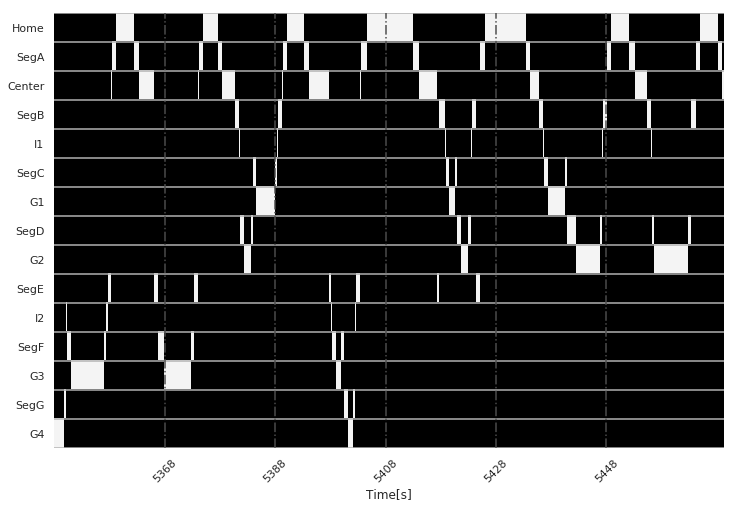

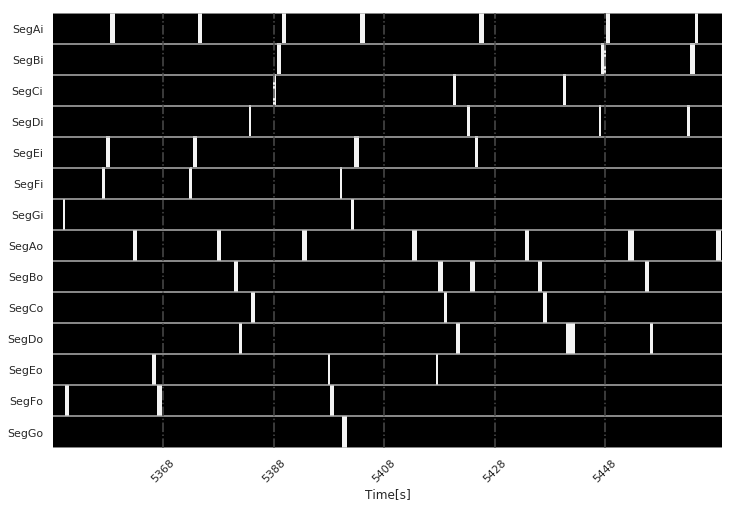

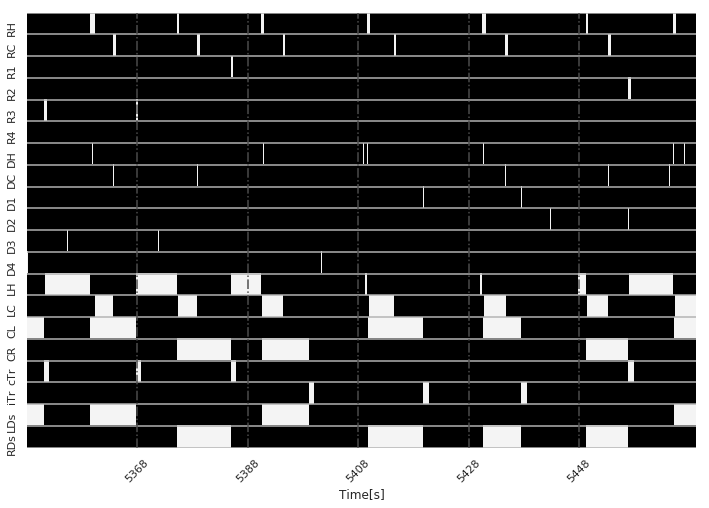

In [2276]:
PF = reload(PF)

##### Plot TMF Zone Counts ######
f=PF.plotMaze_XY(PosDat['x'],PosDat['y'])
f.savefig(sessionPaths['Plots']/'TreeMazeCoverage.png',dpi=500)

##### Plot TMF Zone Counts ######
f = PF.plotMazeZoneCounts(PosDat['PosMat'])
f.savefig(sessionPaths['Plots']/'LocSampleCounts.pdf',dpi=500,bbox_inches='tight',pad_inches=0.2)

### Plot Event Counts ######
f = PF.plotEventCounts(PosDat['EventDat'])
f.savefig(sessionPaths['Plots']/'EventSubsetCounts.pdf',dpi=500, bbox_inches='tight',pad_inches=0.2)

###### Plot TMF Zone Window ######
f,(a1)=plt.subplots(1,1, figsize=(12,8))
a1=PF.plotBehWindow(time_vec[window],PosDat['PosMat'].iloc[window].T,TMF.ZonesNames,a1)
a1.set_xlabel('Time[s]')
f.savefig(sessionPaths['Plots']/('LocWindow_min{}.png').format(minMark_str),dpi=500, bbox_inches='tight',pad_inches=0.2)

###### Plot TMF Segment Directions Window ######
f,(a1)=plt.subplots(1,1, figsize=(12,8))
a1=PF.plotBehWindow(time_vec[window],PosDat['SegDirMat'].iloc[window].T,TMF.SegDirNames,a1)
a1.set_xlabel('Time[s]')
f.savefig(sessionPaths['Plots']/('LocDirWindow_min{}.png').format(minMark_str),dpi=500, bbox_inches='tight',pad_inches=0.2)

###### Plot TMF Events Window ######
f,(a1)=plt.subplots(1,1, figsize=(12,8))
ev_subset=['RH','RC','R1','R2','R3','R4','DH','DC','D1','D2','D3','D4',
             'LH','LC','CL','CR','cTr','iTr','LDs','RDs']
mat = PosDat['EventDat'][ev_subset].iloc[window].T
a1 = PF.plotBehWindow(time_vec[window],mat,ev_subset,a1)
a1.set_xlabel('Time[s]')
f.savefig(sessionPaths['Plots']/('EventWindow_min{}.png').format(minMark_str),dpi=500, bbox_inches='tight',pad_inches=0.2)

##### Behav Window with Cells #####
f,a1,a2= PF.PlotBehavZonesWindowAndSpikes(time_vec[window],PosDat['PosMat'].iloc[window].T,cell_bin_spikes[:,window])
f.savefig(sessionPaths['Plots']/('Cells_LocWindow_min{}.png').format(minMark_str),dpi=500, bbox_inches='tight',pad_inches=0.2)    

##### Behav Window with MuaCells #####
f,a1,a2=PF.PlotBehavZonesWindowAndSpikes(time_vec[window],PosDat['PosMat'].iloc[window].T,mua_bin_spikes[:,window])
f.savefig(sessionPaths['Plots']/('Mua_LocWindow_min{}.png').format(minMark_str),dpi=500, bbox_inches='tight',pad_inches=0.2)    


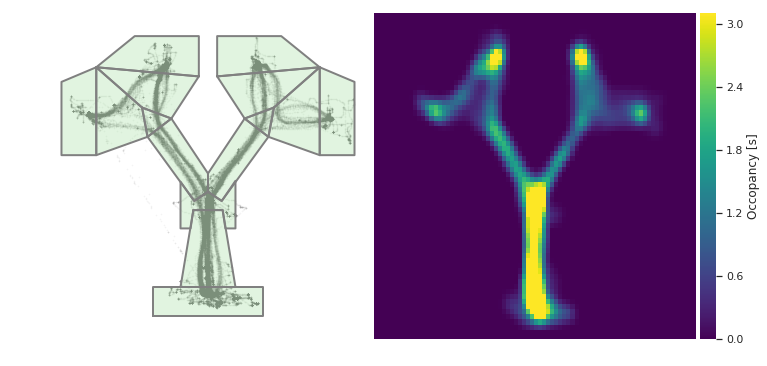

In [2281]:
ST = reload(ST)
TMF = reload(TMF)
PF = reload(PF)

x=np.array(PosDat['x'])
y=np.array(PosDat['y'])
f,(a1,a2,a3)=plt.subplots(1,3, figsize=(12,6),gridspec_kw= dict(width_ratios=(4,4,0.2), height_ratios=[1], wspace=0.02))
a1 = PF.plotTM_Trace(a1,x,y,plot_raw_traces=1)
a1.axis('equal')
a2 = PF.plotHeatMap(a2, a3,OccInfo['time'],colbar_label='Occopancy [s]',robust=True,smooth=True,w=w,s=s)
f.savefig(sessionPaths['Plots']/'OccupancyMap.png',dpi=500, bbox_inches='tight',pad_inches=0.2)

In [1522]:
f_xy=interpolate.interp1d(time_vec.T,np.column_stack((PosDat['x'],PosDat['y'])).T, kind="nearest",fill_value="extrapolate")


In [2303]:
ST = reload(ST)
SF = reload(SF)

cell_id = 15
spikes = cell_bin_spikes[cell_id]
smFR = cell_FR[cell_id]

spikesByPos = ST.getPosBinSpikeMaps(spikes,PosDat,spacing=spacing)
FR_ByPos = ST.getPosBinFRMaps(spikesByPos,OccInfo['time'])
spikesByZone = np.bincount(PosDat['PosZones'],spikes,TMF.nZones).astype(int)
FR_ByZone = np.bincount(PosDat['PosZones'],smFR,TMF.nZones).astype(int)

In [112]:
ZoneRes['Cells']['FR_Zone']

,Home,SegA,Center,SegB,I1,SegC,G1,SegD,G2,SegE,I2,SegF,G3,SegG,G4
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
In,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Out,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Half1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Half2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
for p in ZoneRes['Partitions']:
    ZoneRes['Cells']['']

['all', 'CL', 'CR', 'CO', 'In', 'Out', 'Half1', 'Half2']

In [2309]:
def createAnalysesDict(sessionPaths):
    out = {}
    out['session'] = sessionPaths['session']
    out['Paths'] = sessionPaths
    out['ZoneInfo'] = {'time':[],'counts':[],'prob':[]}
    out['PosInfo'] = {'time':[],'counts':[],'prob':[]}
    out['Cells'] = {}
    out['Mua'] = {}
    
    for a in ['Cells','Mua']:
        out[a]['FR_Zone'] = {'all':[],'CL':[], 'CR':[], 'In':[],'Out':[],'Half1':[],'Half2':[]}
        out[a]['Pos_Zone'] = {'all':[],'CL':[], 'CR':[], 'In':[],'Out':[],'Half1':[],'Half2':[]}
        out[a]['SI_Zone'] = {'all':[],'CL':[], 'CR':[], 'In':[],'Out':[],'Half1':[],'Half2':[]}
              

array([49371, 24032, 30118,  7535,  1523,  2886,  6505,  3617,  9075,
        8423,  1239,  6384, 12352,  3511,  6343])

In [2314]:
OccInfo

{'time': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'counts': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'prob': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

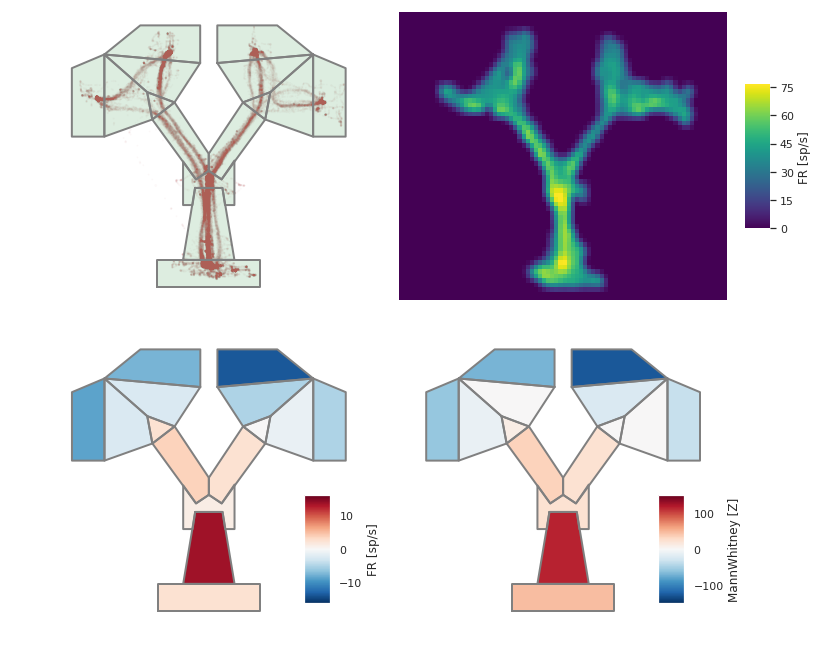

In [2182]:
ST = reload(ST)
StatsF = reload(StatsF)
sns.set()

xPos = [[0.02,0.43],[0.02,0.43]]
yPos = [[0.50,0.50],[0.05,0.05]]
W = 0.38
H = 0.4
#f,ax=plt.subplots(2,3, figsize=(12,6),gridspec_kw= dict(width_ratios=(4,4,0.2), height_ratios=[1,1], wspace=0.02))
f,ax=plt.subplots(2,2, figsize=(12,10))#gridspec_kw= dict(width_ratios=(4,4,0.2), height_ratios=[1,1], wspace=0.02))

ax[0][0]= ST.plotTM_Trace(ax[0][0],PosDat['x'],PosDat['y'],bin_spikes = spikes)
ax[0][0].axis('equal')
ax[0][0].set_position([xPos[0][0],yPos[0][0],W,H])

FR_ByPos[np.isnan(FR_ByPos)]=0
cax1=plt.axes([0.83,0.60,0.03,0.2])
ax[0][1]= ST.plotHeatMap(ax[0][1],cax1,FR_ByPos,smooth=True,w=w,s=s)
ax[0][1].set_position([xPos[0][1],yPos[0][1],W,H])


posdat = PosDat['PosZones'].astype(int)
out = StatsF.getSpikeStats(smFR,posdat)
cax2=plt.axes([0.32,0.08,0.03,0.15])
ax[1][0],cax2=ST.plotZonesHeatMap(ax[1][0],cax2,out['mean']-np.mean(smFR),alpha=1)
cax2.set_ylabel('FR [sp/s]')
ax[1][0].set_position([xPos[1][0],yPos[1][0],W,H])

cax3=plt.axes([0.73,0.08,0.03,0.15])
ax[1][1],cax3=ST.plotZonesHeatMap(ax[1][1],cax3,out['MWUz'],alpha=1)
cax3.set_ylabel('MannWhitney [Z]')
ax[1][1].set_position([xPos[1][1],yPos[1][1],W,H])

f.savefig(sessionPaths['Plots']/('FR_Maps_CellID-{}.png'.format(cell_id)),dpi=500, bbox_inches='tight',pad_inches=0.2)

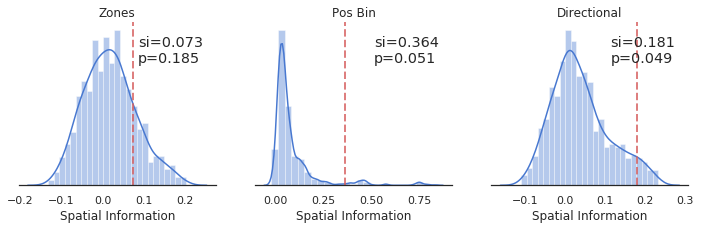

In [2184]:
StF = reload(StF)

f,(a1,a2,a3)=plt.subplots(1,3, figsize=(12,3))
si,si_shf,p = StF.SIPermTest(ZoneInfo['prob'],FR_ByZone)
a1=StF.plotPermDist(a1,si_shf,si,p)
a1.set_title('Zones')

FR_ByPos[OccInfo['prob']==0]=np.nan
si,si_shf,p = StF.SIPermTest(OccInfo['prob'],FR_ByPos)
a2=StF.plotPermDist(a2,si_shf,si,p)
a2.set_title('Pos Bin')

spikesByZoneDir, seqInfo = ST.getDirZoneSpikeMaps(spikes, PosDat)
FR_ByZoneDir = spikesByZoneDir/seqInfo['time']
si,si_shf,p = StF.SIPermTest(seqInfo['prob'],FR_ByZoneDir)
a3=StF.plotPermDist(a3,si_shf,si,p)
a3.set_title('Directional')
f.savefig(sessionPaths['Plots']/('SI_CellID-{}.png'.format(cell_id)),dpi=500, bbox_inches='tight',pad_inches=0.2)

In [2195]:
cl_idx = EventDat['CL'].astype(bool)
cr_idx = EventDat['CR'].astype(bool)
co_idx = ~np.logical_or(cl_idx,cr_idx)

CL_Zones = PosDat['PosZones'].astype(int)[cl_idx]
CR_Zones = PosDat['PosZones'].astype(int)[cr_idx]
CO_Zones = PosDat['PosZones'].astype(int)[co_idx]

CL_ZInfo = ST.getSeqInfo(CL_Zones,PosDat['step'])
CR_ZInfo = ST.getSeqInfo(CR_Zones,PosDat['step'])
CO_ZInfo = ST.getSeqInfo(CO_Zones,PosDat['step'])

SpByCL_Zone = ST.getZoneSpikeMaps(spikes[cl_idx],CL_Zones) 
SpByCR_Zone = ST.getZoneSpikeMaps(spikes[cr_idx],CR_Zones)
SpByCO_Zone = ST.getZoneSpikeMaps(spikes[co_idx],CO_Zones)

FR_CL_Zone = SpByCL_Zone/CL_ZInfo['time']
FR_CR_Zone = SpByCR_Zone/CR_ZInfo['time']
FR_CO_Zone = SpByCL_Zone/CO_ZInfo['time']

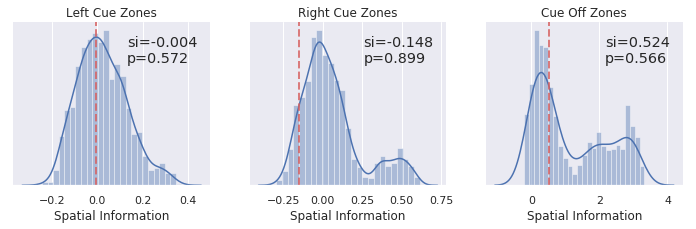

In [2196]:
f,(a1,a2,a3)=plt.subplots(1,3, figsize=(12,3))
si,si_shf,p = StF.SIPermTest(CL_ZInfo['prob'],FR_CL_Zone)
a1=StF.plotPermDist(a1,si_shf,si,p)
a1.set_title('Left Cue Zones')

si,si_shf,p = StF.SIPermTest(CR_ZInfo['prob'],FR_CR_Zone)
a2=StF.plotPermDist(a2,si_shf,si,p)
a2.set_title('Right Cue Zones')

si,si_shf,p = StF.SIPermTest(CO_ZInfo['prob'],FR_CO_Zone)
a3=StF.plotPermDist(a3,si_shf,si,p)
a3.set_title('Cue Off Zones')
f.savefig(sessionPaths['Plots']/('Cue_SI_CellID-{}.png'.format(cell_id)),dpi=500, bbox_inches='tight',pad_inches=0.2)

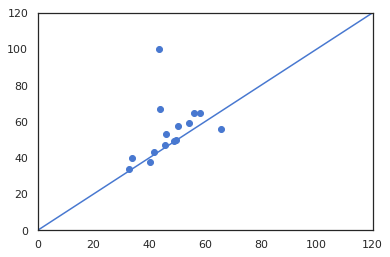

In [2192]:
ax=plt.axes()
ax.scatter(FR_CL_Zone,FR_CR_Zone,)
ax.set_xlim([0,120])
ax.set_ylim([0,120])
ax.plot([0, 1], [0, 1], transform=ax.transAxes)


In [1964]:
def plotBarFR(ax,smFR,groups, groupnames =[]):
    out = StatsF.getSpikeStats(smFR,groups)
    groupIDs = np.unique(groups)
    nGroups = len(groupIDs)
    
    x=np.arange(nGroups)
    ax=sns.barplot(x=x,y=out['mean'],ax=ax, facecolor=(0.5, 0.5, 0.5, 1))
    for g in groupIDs:
        ax.plot([x[g],x[g]],out['conf_Int'][g],color='k',linewidth=3)
    ax.set_xticklabels(groupnames)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    return ax
    

In [2193]:
ST = reload(ST)

movSamps = ST.getValidMovingSamples(PosDat['Speed'])
SegSeq = PosDat['SegDirSeq']
validSamps = np.logical_and(movSamps,SegSeq>0)

mov_spikes = smFR[validSamps]
movSegIDs = SegSeq[validSamps]-1
movSegIDs = movSegIDs.astype(int)

iIDs = np.arange(7)
oIDs = np.arange(7,len(TMF.SegDirNames))

io_stats = StatsF.getSpikeStats(mov_spikes,movSegIDs)
ivo_z = np.arange(7)
for i in iIDs:
    ivo_z[i],_,_=StatsF.getMWUz(mov_spikes,movSegIDs==oIDs[i],movSegIDs==i)

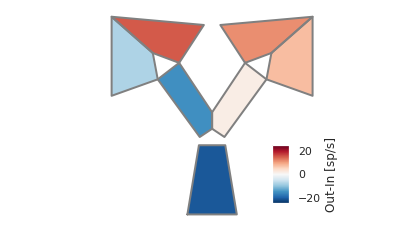

In [2194]:
f,ax=plt.subplots(1)
sns.set()
cax=plt.axes([0.65,0.2,0.04,0.2])
Segs = ['SegA','SegB','SegC','SegD','SegE','SegF','SegG']
ST.plotZonesHeatMap(ax,cax,io_stats['mean'][oIDs]-io_stats['mean'][iIDs],zones=Segs,alpha=1)
cax.set_ylabel('Out-In [sp/s]')
f.savefig(sessionPaths['Plots']/('Dir_Out-In_CellID-{}.png'.format(cell_id)),dpi=500, bbox_inches='tight',pad_inches=0.2)

In [2093]:
p1 = PosDat['PosZones'].astype(int)[EventDat['CL'].astype(bool)]
p2 = PosDat['PosZones'].astype(int)[EventDat['CR'].astype(bool)]
out1 = StatsF.getSpikeStats(smFR[EventDat['CL'].astype(bool)],p1)
out2 = StatsF.getSpikeStats(smFR[EventDat['CR'].astype(bool)],p2)

In [2106]:
LvR_z = np.zeros(TMF.nZones)
p = PosDat['PosZones'].astype(int)
for i in np.arange(TMF.nZones):
    L = np.logical_and(EventDat['CL'].astype(bool), p==i)
    R = np.logical_and(EventDat['CR'].astype(bool), p==i)
    LvR_z[i],_,_=StatsF.getMWUz(smFR,L,R)

In [2107]:
LvR_z

array([-10.34940764,   3.43539551, -10.05176818, -19.12210272,
        -0.3466333 ,   2.07990594,   7.13371544,  -1.02009383,
        -3.69665825,  -0.86540321,   1.66134493,  -8.48838444,
       -11.6857598 ,  -4.52753262,  -3.41023063])

Text(0, 0.5, 'Left - Right [Z]')

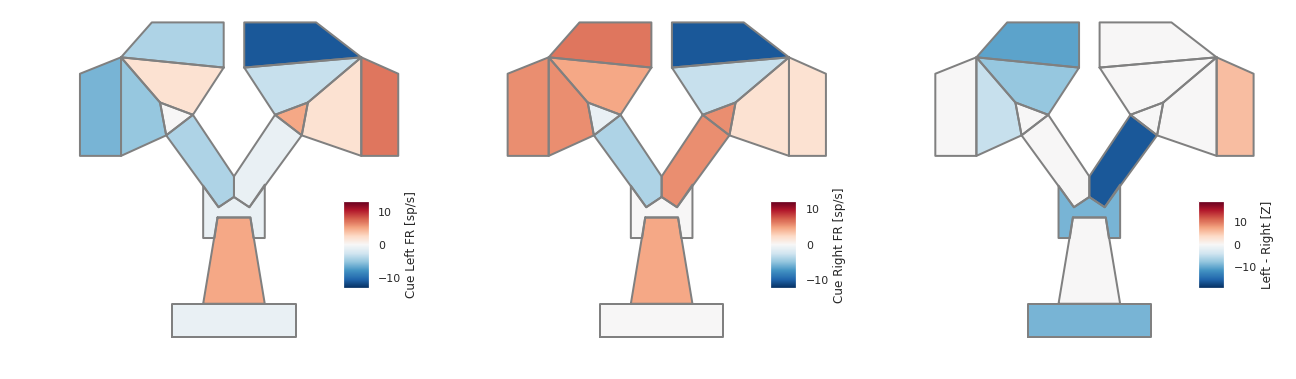

In [2117]:
ST = reload(ST)
StatsF = reload(StatsF)
sns.set()

xPos = [0.02,0.35,0.68]
yPos = 0.1
W = 0.3
H = 0.8

f,ax=plt.subplots(1,3, figsize=(18,6))

cax1 = plt.axes([0.25,0.25,0.02,0.2])
ax[0].set_position([xPos[0],yPos,W,H])
ax[0]= ST.plotZonesHeatMap(ax[0],cax1,out1['mean']-np.mean(smFR),alpha=1)
cax1.set_ylabel('Cue Left FR [sp/s]')

cax2 = plt.axes([0.58,0.25,0.02,0.2])
ax[1].set_position([xPos[1],yPos,W,H])
ax[1]= ST.plotZonesHeatMap(ax[1],cax2,out2['mean']-np.mean(smFR),alpha=1)
cax2.set_ylabel('Cue Right FR [sp/s]')

cax3 = plt.axes([0.91,0.25,0.02,0.2])
ax[2].set_position([xPos[2],yPos,W,H])
LvR_z2=np.array(LvR_z)
LvR_z2[abs(LvR_z)<4]=0
ax[2]= ST.plotZonesHeatMap(ax[2],cax3,LvR_z2,alpha=1)
cax3.set_ylabel('Left - Right [Z]')
#f.savefig(sessionPaths['Plots']/('Cue_FR_Maps_CellID-{}.png'.format(cell_id)),dpi=500, bbox_inches='tight',pad_inches=0.2)

In [2138]:
80/75

1.0666666666666667

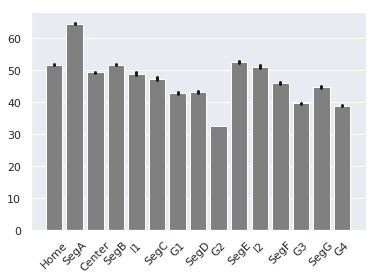

In [2033]:
f,ax=plt.subplots(1)
plotBarFR(ax,smFR,PosDat['PosZones'],groupnames=TMF.ZonesNames)
#len(TMF.MazeZonesGeom)

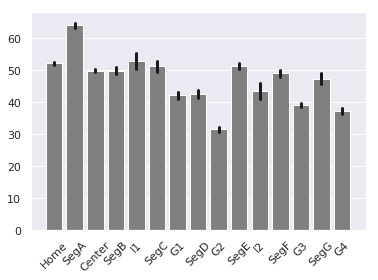

In [2018]:
f,ax=plt.subplots(1)
plotBarFR(ax,spikes/step,PosDat['PosZones'],groupnames=TMF.ZonesNames)

In [1946]:
groups = PosDat['PosZones']
out = StatsF.getSpikeStats(smFR,groups)
nGroups = np.max(groups)
x=np.arange(nGroups)

In [1954]:
out = StatsF.getSpikeStats(smFR,posdat)

In [2034]:
xSP,ySP=ST.binSpikesToXY(spikes,PosDat['x'],PosDat['y'])
P=TMF.getMazeZones(xSP,ySP)

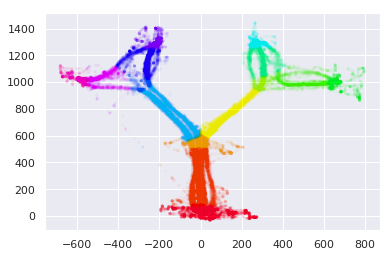

In [2035]:
plt.scatter(xSP,ySP,s=5,c=P,alpha=0.02,cmap='gist_rainbow')


In [1571]:
import scipy.stats as sps
g = 10
g1 = PosDat['PosZones']==g
g2 = PosDat['PosZones']!=g
n1 = np.sum(g1)
n2 = np.sum(g2)
mu = n1*n2/2
su = np.sqrt( n1*n2*(n1+n2+1)/12)
u,p=sps.mannwhitneyu(smFR[g1],smFR[g2])
t,p=sps.ttest_ind(smFR[g1],smFR[g2])
zu = (u-mu)/su
zu2=np.sign(t)*np.abs(zu)
print(zu2,t)


11.632884016408166 6.187461990457627


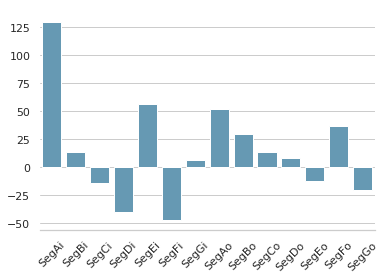

In [1588]:
f,ax=plt.subplots(1)
StatsF = reload(StatsF)
out = StatsF.getSpikeStats(smFR,PosDat['SegDirSeq'].astype(int))
#out['MWUz'][-0]
TMF.plotCounts(out['MWUz'][1:],TMF.SegDirNames,ax)

array([129.5421526 ,  13.83747994, -13.93436786, -39.8274659 ,
        56.36568043, -47.18614654,   6.50540535,  51.51617023,
        29.47251558,  13.30624312,   7.9376364 , -12.81730318,
        36.88117957, -20.36101434])

Text(0.5, 1.0, 'Directional')

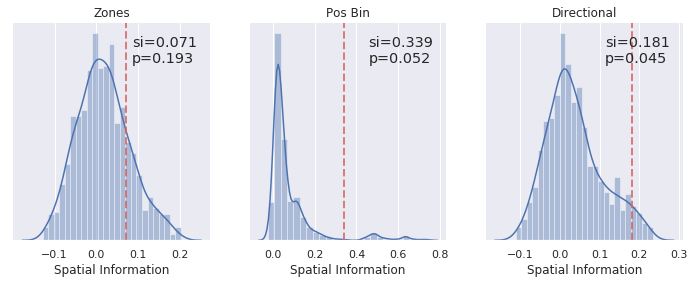

28.868298465261702

In [1995]:
mSp = np.nanmean(spikesByPos)
x=spikesByPos*OccInfo['prob']*np.log2(spikesByPos/mFR)/mFR

/home/alexg8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/home/alexg8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


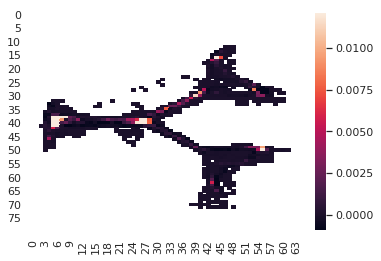

In [1996]:
sns.heatmap(x,robust=True)

In [1465]:
iIDs = np.arange(7)
oIDs = np.arange(7,len(TMF.SegDirNames))

FR_ByZoneDir[oIDs]-FR_ByZoneDir[iIDs]




array([-32.47215291,  14.21976208,  15.1950149 ,  14.48276843,
       -23.76293147,  26.43365028,  -9.97835147])

In [ ]:
def plot_eFR(res,step,selected_params):
    estimatedBaseRate = np.exp(res.params[0])/step
    ci=(np.exp(res.conf_int()[1::])-1)*estimatedBaseRate
    estimatedFRs = (np.exp(res.params[1::])-1)*estimatedBaseRate
    nParams=len(res.params)-1
    x=np.tile(np.arange(nParams),[2,1])
    #sns.barplot(x=np.arange(57),y=np.exp(res.params)-1,ci=np.exp(res.conf_int()-1),capsize=.2)
    
    f,a=plt.subplots(1,1, figsize=(14,5))
    ab=sns.barplot(x=np.arange(nParams),y=estimatedFRs,ax=a, 
                   facecolor=(0.5, 0.5, 0.5, 1))
    for p in np.arange(nParams):
        a.plot(x[:,p],ci.iloc[p],color='k',linewidth=3)
    a.set_ylabel('FR[sp/s]')
    a.set_xticklabels(selected_params)
    #a.grid()
    sns.set_style("whitegrid")
    sns.despine(left=True)
    for tick in a.get_xticklabels():
        tick.set_rotation(45)
    return f,a
        
def plotFitComp(orig,fit,spks,time,a):    
    a.plot(time,orig,color='k',alpha=0.7)
    a.plot(time,fit,color='r',alpha=1)
    a.plot(time,spks,'k',alpha=0.5)
    a.set_ylabel('FR[sp/s]')
    a.set_xlabel('Time[s]')
    a.set_ylim([0,a.get_ylim()[1]])
    return a

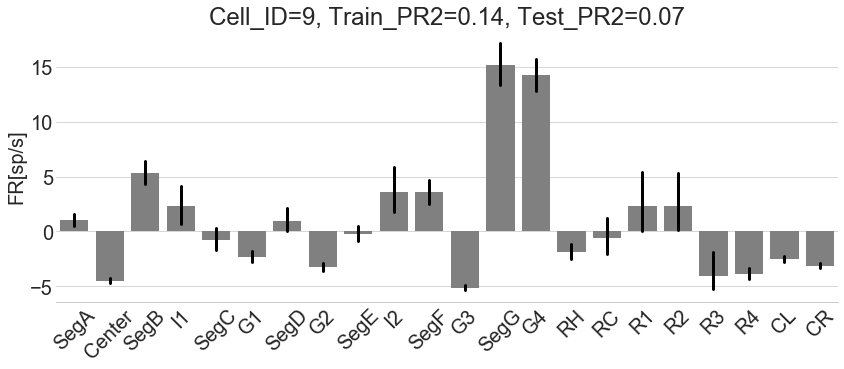

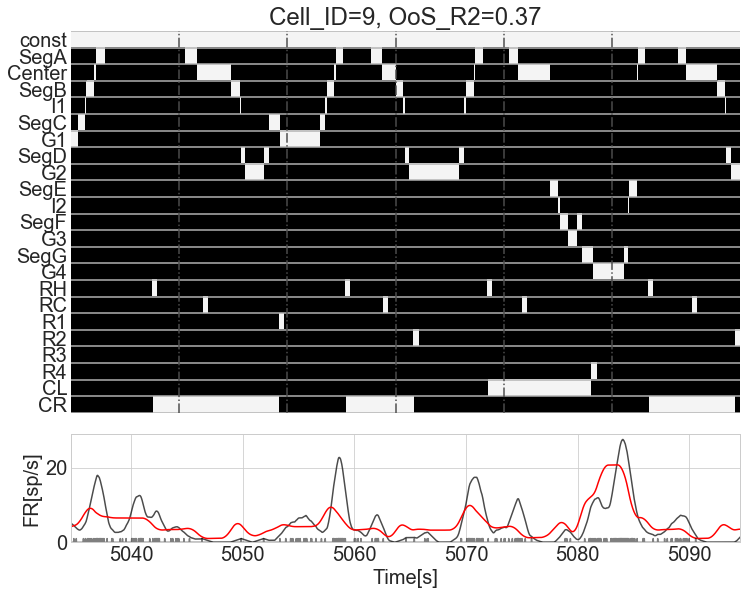

In [189]:
#selected_params = ['Home','SegA','Center','SegB','I1','SegC','G1','SegD',
#                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']
selected_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']

pos_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
              'G2','SegE','I2','SegF','G3','SegG','G4']

reward_params = ['RH','RC','R1','R2','R3','R4']
cue_params = ['CL','CR']
dir_params = TMF.SegDirNames
goal_params = ['Home','Center','G1','G2','G3','G4']

FullMat=pd.concat([PosDat['PosMat'],PosDat['SegDirMat'],EventMat],axis=1)

#selected_params =goal_params+dir_params+reward_params+cue_params
selected_params =pos_params+reward_params+cue_params
#selected_params = pos_params+reward_params+cue_params+dir_params
M2 = sm.add_constant(FullMat[selected_params])

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
time_test = t[xTest.index]
window_test=np.where(np.logical_and(time_test>=minMark,time_test<(minMark+60)))[0]
    
glm_train_fits = {}
PR2_Train = np.zeros(nCells)
PR2_Test = np.zeros(nCells)
R2_Test = np.zeros(nCells)
# Turn interactive plotting off
pltshow = 1
if not pltshow:
    plt.ioff()
    
for cell in [9]:#np.arange(nCells):
    
    y=cell_sp[cell,:]
    if cell>0:
        _, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

    glm_train = sm.GLM(yTrain,xTrain,family = sm.families.Poisson())
    glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
    glm_null_fit = glm_null.fit()
    glm_train_fits[cell] = glm_train.fit()

    PR2_Train[cell] = 1-glm_train_fits[cell].deviance/glm_null_fit.deviance
    muTest =glm_train_fits[cell].predict(xTest)
    TestDev = PDeviance(yTest,muTest)
    muNullTest = glm_null_fit.predict(xTest['const'])
    TestNullDev = PDeviance(yTest,muNullTest)
    PR2_Test[cell] = 1-TestDev/TestNullDev 
    
    f,a= plot_eFR(glm_train_fits[cell],step,selected_params)
    a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_Fits_Cell_{}.pdf'.format(cell),
              bbox_inches='tight',pad_inches=0.2)
    if not pltshow:
        plt.close(f)

    lfwin = np.round(1.0/step).astype(int)
    sm_yTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,yTest)/step
    sm_muTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,muTest.as_matrix())/step

    R2_Test[cell] = np.corrcoef(sm_yTest,sm_muTest)[0,1]**2
    
    
    f,(a1,a2)=plt.subplots(2,1, figsize=(12,10))
    a1.set_position([0.125, 0.38, 0.775, 0.53])
    a1=plotBehWindow(time_test[window_test],xTest.iloc[window_test].T,xTest.columns,a1)
    a1.set_xticks([])    
    a1.set_title('Cell_ID={0}, OoS_R2={1:0.2f}'.format(cell,R2_Test[cell]))

    a2.set_position([0.125, 0.2, 0.775, 0.15])
    a2=plotFitComp(sm_yTest[window_test],sm_muTest[window_test],
                   yTest[window_test]>0,time_test[window_test],a2 )
    a2.set_xlim(time_test[window_test][0],time_test[window_test][-1])
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_FR_Plot_Cell_{}.png'.format(cell),
              dpi=500,bbox_inches='tight',pad_inches=0.2)  
    if not pltshow:
        plt.close(f)

In [342]:
def plot_eFR2(res,baseRate,step,selected_params):
    ci=(np.exp(res.conf_int())-baseRate)/step
    estimatedFRs = (np.exp(res.params)-baseRate)/step
    nParams=len(res.params)
    x=np.tile(np.arange(nParams),[2,1])
    #sns.barplot(x=np.arange(57),y=np.exp(res.params)-1,ci=np.exp(res.conf_int()-1),capsize=.2)
    
    f,a=plt.subplots(1,1, figsize=(14,5))
    ab=sns.barplot(x=np.arange(nParams),y=estimatedFRs,ax=a, 
                   facecolor=(0.5, 0.5, 0.5, 1))
    for p in np.arange(nParams):
        a.plot(x[:,p],ci.iloc[p],color='k',linewidth=3)
    a.set_ylabel('FR[sp/s]')
    a.set_xticklabels(selected_params)
    #a.grid()
    sns.set_style("whitegrid")
    sns.despine(left=True)
    for tick in a.get_xticklabels():
        tick.set_rotation(45)
    return f,a

In [491]:
def plot_params(params,ci,selected_params):

    nParams=len(params)
    x=np.tile(np.arange(nParams),[2,1])
    
    f,a=plt.subplots(1,1, figsize=(14,5))
    ab=sns.barplot(x=np.arange(nParams),y=params,ax=a, 
                   facecolor=(0.5, 0.5, 0.5, 1))
    for p in np.arange(nParams):
        a.plot(x[:,p],ci.iloc[p],color='k',linewidth=3)
        
    a.set_ylabel('PE [au]')
    a.set_xticklabels(selected_params)
    #a.grid()
    sns.set_style("whitegrid")
    sns.despine(left=True)
    for tick in a.get_xticklabels():
        tick.set_rotation(45)
    return f,a

In [500]:
model = 'Complete'

pos_params = ['Home','SegA','Center','SegB','I1','SegC','G1','SegD',
              'G2','SegE','I2','SegF','G3','SegG','G4']

reward_params = ['RH','RC','R1','R2','R3','R4']
cue_params = ['CL','CR']
dir_params = TMF.SegDirNames
goal_params = ['Home','Center','G1','G2','G3','G4']

sp = '/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots'

PlotDir = Path(sp,model)
PlotDir.mkdir(parents=True, exist_ok=True)

FullMat=pd.concat([PosDat['PosMat'],PosDat['SegDirMat'],EventMat],axis=1)

if model=='Complete':
    selected_params = pos_params + reward_params + cue_params
    M2 = sm.add_constant(FullMat[selected_params])
elif model=='Rewards':
    selected_params = reward_params
    M2 = sm.add_constant(FullMat[reward_params])
elif model=='Cues':
    selected_params = cue_params
    M2 = sm.add_constant(FullMat[reward_params])

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
time_test = t[xTest.index]
window_test=np.where(np.logical_and(time_test>=minMark,time_test<(minMark+60)))[0]
    
glm_train_fits = {}
PR2_Train = np.zeros(nCells)
PR2_Test = np.zeros(nCells)
R2_Test = np.zeros(nCells)
TrainBaseRate = np.zeros(nCells)
nParams = len(selected_params)
ZVals = pd.DataFrame(np.zeros((nCells,nParams)),columns=selected_params)
ParamsEst = pd.DataFrame(np.zeros((nCells,nParams)),columns=selected_params)
PVals = pd.DataFrame(np.zeros((nCells,nParams)),columns=selected_params)
plotFlag = 1
pltshow = 0
if not pltshow:
    plt.ioff()
    
for cell in np.arange(nCells):
    
    y=cell_sp[cell,:]
    if cell>0:
        _, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

    TrainBaseRate[cell] = np.mean(yTrain)
    
    # train model and firt to test set
    if model=='Complete':
        glm_train = sm.GLM(yTrain,xTrain.drop(['const'],axis=1),family = sm.families.Poisson())
        glm_train_fits[cell] = glm_train.fit()
        muTest =glm_train_fits[cell].predict(xTest.drop(['const'],axis=1))
    else:
        glm_train = sm.GLM(yTrain,xTrain,family = sm.families.Poisson())
        glm_train_fits[cell] = glm_train.fit()
        muTest =glm_train_fits[cell].predict(xTest)
        
    
    # get null / constant model fits
    glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
    glm_null_fit = glm_null.fit()
    muNullTest = glm_null_fit.predict(xTest['const'])
   
    # get performance metrics
    PR2_Train[cell] = 1-glm_train_fits[cell].deviance/glm_null_fit.deviance
    TestDev = PDeviance(yTest,muTest)
    TestNullDev = PDeviance(yTest,muNullTest)
    PR2_Test[cell] = 1-TestDev/TestNullDev 
    
    # Store parameters
    ZVals.iloc[cell] = glm_train_fits[cell].tvalues
    ParamsEst.iloc[cell] = np.exp(glm_train_fits[cell].params)
    PVals.iloc[cell]=glm_train_fits[cell].pvalues

    # smooth binned spikes to obtain FRs
    lfwin = np.round(0.5/step).astype(int)
    sm_yTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,yTest)/step
    sm_muTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,muTest.as_matrix())/step

    R2_Test[cell] = np.corrcoef(sm_yTest,sm_muTest)[0,1]**2
    
    # plot results
    if plotFlag:
        f,a= plot_params(glm_train_fits[cell].params,glm_train_fits[cell].conf_int(),selected_params)
        a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
        f.savefig(('{}/{}_GLM_Fits_RawParams_Cell_{}.pdf').format(sp,model,cell),bbox_inches='tight',pad_inches=0.2)
        if not pltshow:
            plt.close(f)
        
        f,a= plot_eFR2(glm_train_fits[cell],TrainBaseRate[cell],step,selected_params)
        a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
        f.savefig(('{}/{}_GLM_Fits_eFRs_Cell_{}.pdf').format(sp,model,cell),bbox_inches='tight',pad_inches=0.2)
        if not pltshow:
            plt.close(f)
        
        f,(a1,a2)=plt.subplots(2,1, figsize=(12,10))
        a1.set_position([0.125, 0.38, 0.775, 0.53])
        a1=plotBehWindow(time_test[window_test],xTest.iloc[window_test].T,xTest.columns,a1)
        a1.set_xticks([])    
        a1.set_title('Cell_ID={0}, OoS_R2={1:0.2f}'.format(cell,R2_Test[cell]))

        a2.set_position([0.125, 0.2, 0.775, 0.15])
        a2=plotFitComp(sm_yTest[window_test],sm_muTest[window_test],
                       yTest[window_test]>0,time_test[window_test],a2 )
        a2.set_xlim(time_test[window_test][0],time_test[window_test][-1])
        f.savefig(('{}/{}_GLM_TestWindow_Cell_{}.png').format(sp,model,cell),dpi=500,bbox_inches='tight',pad_inches=0.2)

        if not pltshow:
            plt.close(f)

False

In [465]:
cell=14
y=cell_sp[cell,:]
_, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
glm_train = sm.GLM(yTrain,xTrain.drop(['const'],axis=1),family = sm.families.Poisson())
glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
glm_null_fit = glm_null.fit()
glm_train_fits[cell] = glm_train.fit()


In [482]:
pa='Center'
np.mean(yTrain[xTrain[pa]])/step,ParamsEst[pa].loc[cell]/step


(41.20304540110843, 11.759082376029667)

In [350]:
np.exp(glm_train_fits[cell].params['Home'])

10.86690070351715

In [487]:
#X=(np.ParamsEst[reward_params]-np.tile(TrainBaseRate,[len(reward_params),1]).T>0)*(PVals[reward_params]*nParams*nCells<0.001)

X=np.log(ParamsEst[reward_params])
X

,RH,RC,R1,R2,R3,R4
0,-0.145369,-0.071356,-0.251186,0.084414,-0.155944,-0.161971
1,-0.273723,0.082610,-0.087069,0.063380,-0.075489,-0.143872
2,-0.238234,-0.028081,-0.192796,-0.140183,-0.221809,-0.211014
3,-0.349746,-0.303213,-0.316235,0.003384,-0.144198,-0.153547
4,-0.086459,0.024052,-0.012363,0.104985,-0.101691,-0.035850
5,-0.131548,-2.341411,1.003434,-3.139073,0.135233,-0.711476
6,-0.405218,-0.342229,-0.127765,-0.294339,-0.393689,0.105613
7,-0.213623,-0.141371,-0.020254,-0.424119,-0.227082,-0.050577
8,-1.464796,-0.297631,-1.468727,0.400991,-1.033215,-0.645258
9,-0.340246,-0.100228,0.303637,0.307330,-0.954118,-0.892103


In [451]:
ZVals[reward_params].loc[14]

RH   -1.858327
RC   -7.645602
R1   -2.643148
R2   -2.817244
R3   -5.176846
R4   -3.649426
Name: 14, dtype: float64

Home      21.654222
SegA       9.236695
Center    -3.598920
SegB       8.897570
I1         5.604045
SegC       2.538475
G1        -5.041505
SegD       6.656821
G2        -9.029404
SegE       1.538201
I2         6.617961
SegF       1.846251
G3        -8.476314
SegG       8.796445
G4        -0.467933
RH        32.189901
RC        14.020176
R1        20.154315
R2        18.046659
R3         6.178264
R4        20.478647
CL        15.781963
CR        12.592349
dtype: float64

In [357]:
(ParamsEst[['CL','CR']].as_matrix()>0)*(PVals[['CL','CR']]*nParams*nCells<0.001).as_matrix()

array([[False, False],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True, False],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False]])

In [392]:
pa = 'Center'
((ParamsEst[pa]-TrainBaseRate)>0)*(PVals[pa]<0.001)*R2_Test>0.3

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15     True
16    False
17    False
18    False
19     True
20    False
Name: Center, dtype: bool

In [409]:
np.sqrt(R2_Test)[R2_Test>0.5]

array([0.79096877])

In [414]:
200

4.315789473684211

In [936]:
#selected_params = ['Home','SegA','Center','SegB','I1','SegC','G1','SegD',
#                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']
selected_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']

pos_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
              'G2','SegE','I2','SegF','G3','SegG','G4']

reward_params = ['RH','RC','R1','R2','R3','R4']
cue_params = ['CL','CR']
dir_params = TMF.SegDirNames
goal_params = ['Home','Center','G1','G2','G3','G4']

FullMat=pd.concat([PosDat['PosMat'],PosDat['SegDirMat'],EventMat],axis=1)

#selected_params =goal_params+dir_params+reward_params+cue_params
selected_params =pos_params+reward_params+cue_params
#selected_params = pos_params+reward_params+cue_params+dir_params
M2 = sm.add_constant(FullMat[selected_params])

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

In [185]:
RewardMat = EventMat[reward_params]

detect_params = ['DH','DC','D1','D2','D3','D4']
DetecMat = EventMat[detect_params] 
reLength = 1/step # one second
deLength = 1.5*1/step # two secs

for r in reward_params:
    RewardMat[r] = (signal.lfilter(np.arange(reLength),1,RewardMat[r])>0).astype(int)
    
for d in detect_params:
    DetecMat[d] = (signal.lfilter(np.arange(deLength),1,DetecMat[d])>0).astype(int)
    
cnt = 0


In [187]:
ReDeMat=pd.concat([DetecMat,RewardMat],axis=1)
selected_params = detect_params+reward_params
M2 = sm.add_constant(ReDeMat)

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
time_test = t[xTest.index]
window_test=np.where(np.logical_and(time_test>=minMark,time_test<(minMark+60)))[0]
    
glm_train_fits = {}
PR2_Train = np.zeros(nCells)
PR2_Test = np.zeros(nCells)
R2_Test = np.zeros(nCells)
# Turn interactive plotting off
plt.ioff()
for cell in np.arange(nCells):
    
    if cell>0:
        y=cell_sp[cell,:]
        _, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

    glm_train = sm.GLM(yTrain,xTrain,family = sm.families.Poisson())
    glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
    glm_null_fit = glm_null.fit()
    glm_train_fits[cell] = glm_train.fit()

    PR2_Train[cell] = 1-glm_train_fits[cell].deviance/glm_null_fit.deviance
    muTest =glm_train_fits[cell].predict(xTest)
    TestDev = PDeviance(yTest,muTest)
    muNullTest = glm_null_fit.predict(xTest['const'])
    TestNullDev = PDeviance(yTest,muNullTest)
    PR2_Test[cell] = 1-TestDev/TestNullDev 
    
    f,a= plot_eFR(glm_train_fits[cell],step,selected_params)
    a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_FitsReDe_Cell_{}.pdf'.format(cell),
              bbox_inches='tight',pad_inches=0.2)    
    plt.close(f)

    lfwin = np.round(1.0/step).astype(int)
    sm_yTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,yTest)/step
    sm_muTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,muTest.as_matrix())/step

    R2_Test[cell] = np.corrcoef(sm_yTest,sm_muTest)[0,1]**2
     
    f,(a1,a2)=plt.subplots(2,1, figsize=(12,10))
    a1.set_position([0.125, 0.38, 0.775, 0.53])
    a1=plotBehWindow(time_test[window_test],xTest.iloc[window_test].T,xTest.columns,a1)
    for tick in a1.get_yticklabels():
        tick.set_rotation(0)
    
    a1.set_xticks([])    
    a1.set_title('Cell_ID={0}, OoS_R2={1:0.2f}'.format(cell,R2_Test[cell]))

    a2.set_position([0.125, 0.2, 0.775, 0.15])
    a2=plotFitComp(sm_yTest[window_test],sm_muTest[window_test],
                   yTest[window_test]>0,time_test[window_test],a2 )
    a2.set_xlim(time_test[window_test][0],time_test[window_test][-1])
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_FR_ReDe_Plot_Cell_{}.png'.format(cell),
              dpi=500,bbox_inches='tight',pad_inches=0.2)  
    plt.close(f)
plt.show()

In [182]:
M2

,const,DH,DC,D1,D2,D3,D4,RH,RC,R1,R2,R3,R4
0,1.0,False,False,False,False,False,False,False,False,False,False,False,False
1,1.0,False,False,False,False,False,False,False,False,False,False,False,False
2,1.0,False,False,False,False,False,False,False,False,False,False,False,False
3,1.0,False,False,False,False,False,False,False,False,False,False,False,False
4,1.0,False,False,False,False,False,False,False,False,False,False,False,False
5,1.0,False,False,False,False,False,False,False,False,False,False,False,False
6,1.0,False,False,False,False,False,False,False,False,False,False,False,False
7,1.0,False,False,False,False,False,False,False,False,False,False,False,False
8,1.0,False,False,False,False,False,False,False,False,False,False,False,False
9,1.0,False,False,False,False,False,False,False,False,False,False,False,False
